## code
Got idea from this post: https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323

## data
Google Analytics Sample mockup data

In [12]:
import pandas as pd
import ast
from collections import defaultdict

In [7]:
def convert_str_to_list(str_):
    
    return ast.literal_eval(str_)

In [8]:
df = pd.read_csv("example_marketing.csv")

df['path_list'] = df['path'].apply(lambda x: convert_str_to_list(x))
df.head()

,device,path,path_list
0,1,"['Start', 'Instagram', 'Online Display', 'Null']","[Start, Instagram, Online Display, Null]"
1,2,"['Start', 'Paid Search', 'Null']","[Start, Paid Search, Null]"
2,3,"['Start', 'Paid Search', 'Null']","[Start, Paid Search, Null]"
3,4,"['Start', 'Instagram', 'Null']","[Start, Instagram, Null]"
4,5,"['Start', 'Paid Search', 'Null']","[Start, Paid Search, Null]"


In [25]:
list_of_paths = df['path_list']

total_conversions = sum(path.count('Conversion') for path in df['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

base_conversion_rate

0.1

In [9]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states




trans_states = transition_states(list_of_paths)

In [13]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [14]:
trans_prob

defaultdict(dict,
            {'Paid Search>Conversion': 0.16666666666666666,
             'Paid Search>Null': 0.8333333333333334,
             'Facebook>Conversion': 0.25,
             'Facebook>Null': 0.75,
             'Online Display>Null': 0.8,
             'Online Display>Instagram': 0.2,
             'Instagram>Facebook': 0.2222222222222222,
             'Instagram>Online Display': 0.3333333333333333,
             'Instagram>Null': 0.4444444444444444,
             'Start>Paid Search': 0.3,
             'Start>Facebook': 0.1,
             'Start>Online Display': 0.05,
             'Start>Instagram': 0.4,
             'Start>Youtube': 0.15,
             'Youtube>Online Display': 0.3333333333333333,
             'Youtube>Null': 0.6666666666666666})

In [16]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [17]:
trans_matrix

,Paid Search,Facebook,Online Display,Conversion,Null,Instagram,Start,Youtube
Paid Search,0.0,0.000000,0.000000,0.166667,0.833333,0.0,0.0,0.00
Facebook,0.0,0.000000,0.000000,0.250000,0.750000,0.0,0.0,0.00
Online Display,0.0,0.000000,0.000000,0.000000,0.800000,0.2,0.0,0.00
Conversion,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.00
Null,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00
Instagram,0.0,0.222222,0.333333,0.000000,0.444444,0.0,0.0,0.00
Start,0.3,0.100000,0.050000,0.000000,0.000000,0.4,0.0,0.15
Youtube,0.0,0.000000,0.333333,0.000000,0.666667,0.0,0.0,0.00


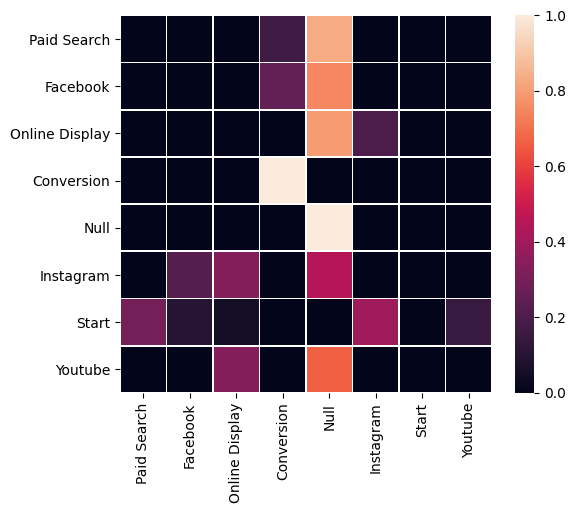

In [22]:
import seaborn as sns
import matplotlib.pylab as plt

fig=plt.figure(figsize=(6,5), dpi= 100, facecolor='w', edgecolor='k')
ax = sns.heatmap(trans_matrix, linewidth=0.5)
plt.show()

In [26]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [27]:
removal_effects_dict

{'Paid Search': 0.5,
 'Facebook': 0.5,
 'Online Display': 0.0277777777777779,
 'Instagram': 0.2500000000000001,
 'Youtube': 0.005952380952381042}

In [28]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [29]:
attributions

{'Paid Search': 0.7789799072642966,
 'Facebook': 0.7789799072642966,
 'Online Display': 0.04327666151468333,
 'Instagram': 0.38948995363214844,
 'Youtube': 0.0092735703245751}